# Modifications de résultats des sondages

## Import préliminaires des librairies

In [221]:
%pylab inline
# Command OS
import os

# Regex
import re

# Calcul and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm
# Dealing with specific representation of number
# Aka commat in french in numbers
import locale
from locale import atof

### Dark theme pour matplotlib ###
from ing_theme_matplotlib import mpl_style
mpl_style(dark=True)


Populating the interactive namespace from numpy and matplotlib
D:\Programmes\Python3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Import du dataframe

## Calcul de l'erreur à 95% de confiance

In [222]:
def error_p(p,n=1000,Za=1.96):
    return np.sqrt(p*(1-p)/n)*Za
error_p(0.48,300)

0.05653504399927535

## Calcul de l'intervalle de confiance

In [223]:
def margin_p(p,n=1000,Za=1.96):
    er=error_p(p,n,Za)
    return np.array([p-er,p+er])


In [224]:
def error_in_margin(p,n,variation,Za=1.96,double_margin=True):
    # Compute old values
    old_p=p-variation
    # Compute err
    err=error_p(p/100,n,Za)*100
    # Compute err old values
    old_err=error_p(old_p/100,n,Za)*100
    if double_margin:
        return (np.abs(variation)<=error_p(p/100,n,2.328)*100) & variation!=0
    else:
        return (np.abs(variation)<=err) & variation!=0


In [225]:
def extract_in_margin(fav,defav,evol_fav,evol_defav,pop_size,double_margin=True):
    # Suppression des valeurs sans variation
    fav=fav[evol_fav!=0]
    defav=defav[evol_defav!=0]
    pop_size_fav=pop_size[evol_fav!=0]
    pop_size_defav=pop_size[evol_defav!=0]
    evol_fav=evol_fav[evol_fav!=0]
    evol_defav=evol_defav[evol_defav!=0]

    # Calcul des erreurs
    err_fav=error_p(fav/100,pop_size_fav)*100
    err_defav=error_p(defav/100,pop_size_defav)*100

    # Calcul des anciennes valeurs
    old_fav=fav-evol_fav
    old_defav=defav-evol_defav
    # Calcul des erreurs anciennes valeurs
    err_old_fav=error_p(old_fav/100,pop_size_fav)*100
    err_old_defav=error_p(old_defav/100,pop_size_defav)*100
    if double_margin:
        total_fav_in_margin=np.sum(err_fav+err_old_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav+err_old_defav>=np.abs(evol_defav))
    else:
        total_fav_in_margin=np.sum(err_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav>=np.abs(evol_defav))
    total_in_margin=total_fav_in_margin+total_defav_in_margin
    total_lines=len(fav)+len(defav)

    return (total_in_margin,total_lines)

In [226]:
filenames=[f.rstrip('.p') for f in os.listdir('data')]
sum_in_margin=0
total_lines=0
df=pd.read_pickle("data/2020-03-20.p")
data_f=pd.DataFrame(columns=df.columns)
for fn in filenames:
    df=pd.read_pickle("data/{}.p".format(fn))
    df.Base=df.Base.astype('float')
    df['Date']=fn
    data_f=pd.concat([data_f,df])
    in_margin,nb_lines=extract_in_margin(df['ST Favorable'],df['ST Défavorable'],df['Evolution ST Favorable'],df['Evolution ST Défavorable'],df.Base)
    sum_in_margin+=in_margin
    total_lines+=nb_lines
data_f.Date=data_f.Date.astype('datetime64')
print(sum_in_margin/total_lines)



D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)

In [227]:
Nom ='Edouard PHILIPPE'
d_margin_err=True

data_f['Inexploitable Favorable']=error_in_margin(data_f['ST Favorable'],data_f["Base"],data_f['Evolution ST Favorable'],double_margin=d_margin_err)
data_f['Inexploitable Défavorable']=error_in_margin(data_f['ST Défavorable'],data_f["Base"],data_f['Evolution ST Défavorable'],double_margin=d_margin_err)
data_f['Erreur Th Favorable']=error_p(data_f['ST Favorable']/100,data_f["Base"])*100
data_f['Erreur Th Défavorable']=error_p(data_f['ST Défavorable']/100,data_f["Base"],)*100
data_f['Inexploitable Favorable'].value_counts()
data_f['Inexploitable Défavorable'].value_counts()
df_inex=pd.DataFrame()
df_inex['Résultats']=pd.concat([data_f['ST Favorable'],data_f['ST Défavorable']])
df_inex['Categorie']=pd.concat([data_f['Categorie'],data_f['Categorie']])
df_inex['Inexploitable']=pd.concat([data_f['Inexploitable Favorable'],data_f['Inexploitable Défavorable']])
df_inex['Nom']=pd.concat([data_f['Nom'],data_f['Nom']])
groupe=df_inex[df_inex.Categorie=='ENSEMBLE']

data_f[data_f.Nom==Nom]


D:\Programmes\Python3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
70,Edouard PHILIPPE,ENSEMBLE,ENSEMBLE,971.0,3.6,26.3,30.0,29.1,17.2,46.3,23.8,1.4,-2.5,2018-12-08,True,True,2.882412,3.136347
71,Edouard PHILIPPE,Sexe,Homme,462.0,5.2,29.7,34.9,31.6,19.4,51.0,14.1,1.7,-1.1,2018-12-08,True,True,4.346486,4.558461
72,Edouard PHILIPPE,Sexe,Femme,509.0,2.2,23.3,25.5,26.8,15.2,42.0,32.5,1.1,-3.8,2018-12-08,True,True,3.786565,4.287813
73,Edouard PHILIPPE,Age,18à24ans,103.0,7.5,14.8,22.3,22.8,10.9,33.8,44.0,3.4,-0.9,2018-12-08,True,True,8.038970,9.135342
74,Edouard PHILIPPE,Age,25à34ans,154.0,0.2,13.1,13.3,26.2,18.2,44.4,42.3,-8.9,-3.2,2018-12-08,False,True,5.363288,7.847378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Edouard PHILIPPE,VotePrésidentielle20171ertour,STNonexpr,252.0,6.3,35.7,42.0,20.4,14.4,34.8,23.2,-1.4,-3.9,2021-03-06,True,True,6.093888,5.881244
2376,Edouard PHILIPPE,VotePrésidentielle20172ndtour,EmmanuelMacron,416.0,24.3,43.0,67.3,17.3,6.3,23.6,9.1,1.4,-4.5,2021-03-06,True,True,4.508072,4.080488
2377,Edouard PHILIPPE,VotePrésidentielle20172ndtour,MarineLePen,214.0,10.4,35.3,45.7,21.6,23.8,45.4,8.9,8.3,-8.4,2021-03-06,False,False,6.674323,6.670731
2378,Edouard PHILIPPE,VotePrésidentielle20172ndtour,STExpr,630.0,19.5,40.4,60.0,18.7,12.3,31.0,9.0,3.7,-5.8,2021-03-06,True,False,3.825528,3.611530


## Inexploitable global

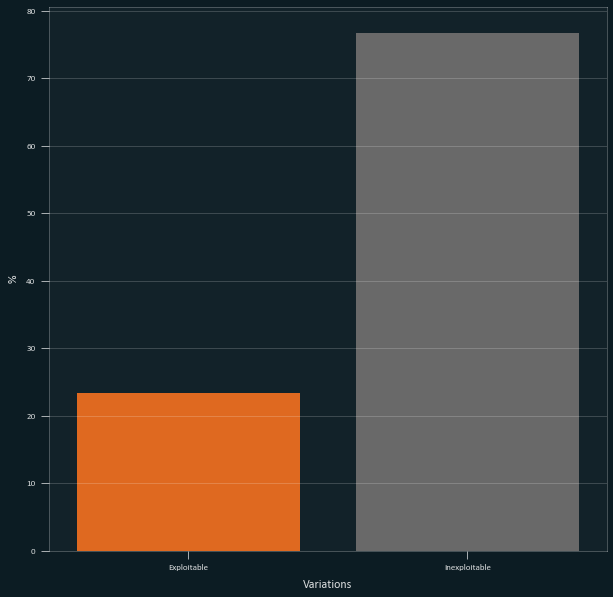

In [228]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex, estimator=lambda x: len(x) / len(df_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.svg')

In [229]:
print(df_inex.Inexploitable.value_counts())
df_inex.Inexploitable.value_counts()/len(df_inex)

True     59913
False    18207
Name: Inexploitable, dtype: int64


True     0.766935
False    0.233065
Name: Inexploitable, dtype: float64

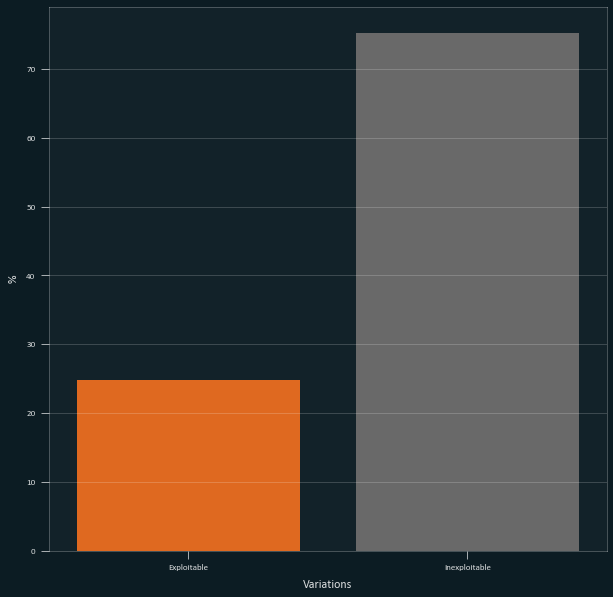

In [230]:
df_inex_ens=df_inex[df_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex_ens, estimator=lambda x: len(x) / len(df_inex_ens) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.svg')


In [231]:
print(df_inex_ens.Inexploitable.value_counts())
df_inex_ens.Inexploitable.value_counts()/len(df_inex_ens)

True     840
False    276
Name: Inexploitable, dtype: int64


True     0.752688
False    0.247312
Name: Inexploitable, dtype: float64

## Inexploitable sur groupe ENSEMBLE (seulement tous les sondés)

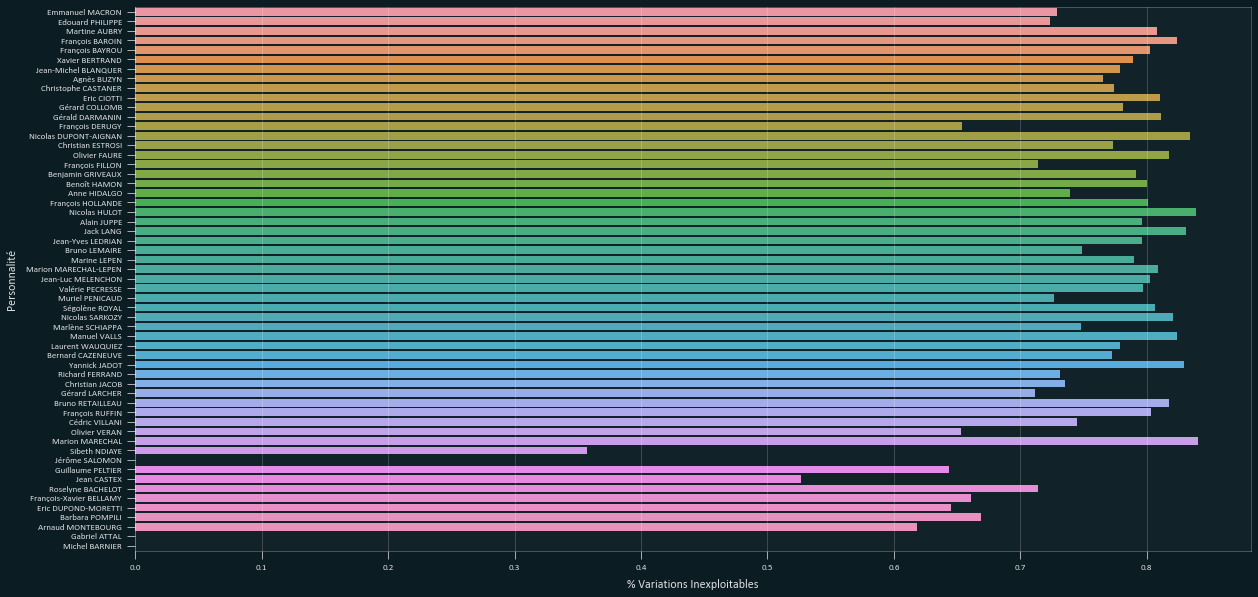

In [232]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [233]:
print(df_inex_ens['Inexploitable'].value_counts()/len(groupe))
print(df_inex_ens['Inexploitable'].value_counts())
# data_f['Inexploitable Défavorable'].value_counts()

True     0.752688
False    0.247312
Name: Inexploitable, dtype: float64
True     840
False    276
Name: Inexploitable, dtype: int64


## Inexploitable sur toutes les variations

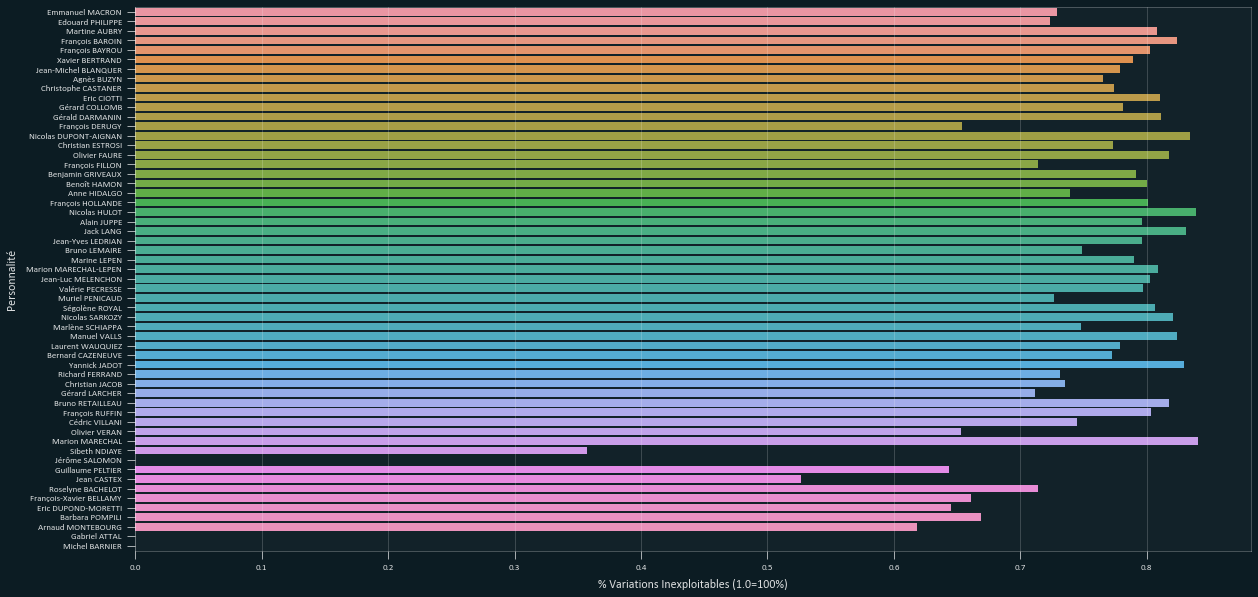

In [236]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex,ci=None\
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [219]:
print(df_inex['Inexploitable'].value_counts()/len(df_inex))
print(df_inex['Inexploitable'].value_counts())

True     0.766935
False    0.233065
Name: Inexploitable, dtype: float64
True     59913
False    18207
Name: Inexploitable, dtype: int64


## Taille échantillons groupes de gauche

In [180]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

EELV                       558
LR                         558
PS                         558
STCentre(ModemLREM)        558
UDI                        558
LREM                       558
STFIPdGPC                  558
RN                         558
STGauche(FIPdGPCPSEELV)    558
Aucunparti                 558
STDroite(LRUDI)            558
MoDem                      558
DLF                        558
Name: Groupe, dtype: int64

In [181]:
filtre_soutien_gauche= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC') # | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
filtre_soutien_gauche_full= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC')  | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']]
# test_df=taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail=data_f[filtre_soutien_gauche][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail.rename(columns={'STFIPdGPC':'FI-PdG-PC'}, inplace=True)
taille_gauche_detail=taille_gauche_detail[['FI-PdG-PC','PS','EELV']]
taille_gauche_full.replace('STFIPdGPC','FI-PdG-PC',inplace=True)
taille_gauche_full.replace('STGauche(FIPdGPCPSEELV)','Soutien Gauche (Total)',inplace=True)

### Plot stack

(0.0, 350.0)

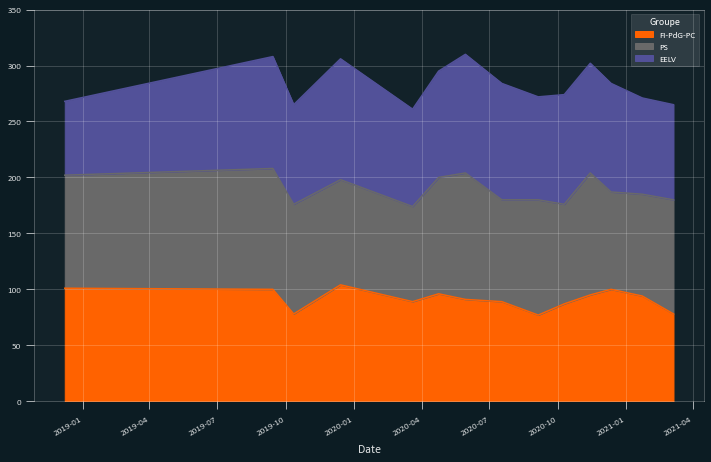

In [182]:

# fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
# ax=sns.lineplot(data=taille_echantillon_gauche,x='Date',y='Base')

ax=taille_gauche_detail.plot.area(figsize=(12,8))
taille_gauche_detail
ax.set_ylim(0,350)

### Plot line

In [183]:
taille_gauche_full["Erreur"]=error_p(taille_gauche_full.Base/1000,1000)*1000


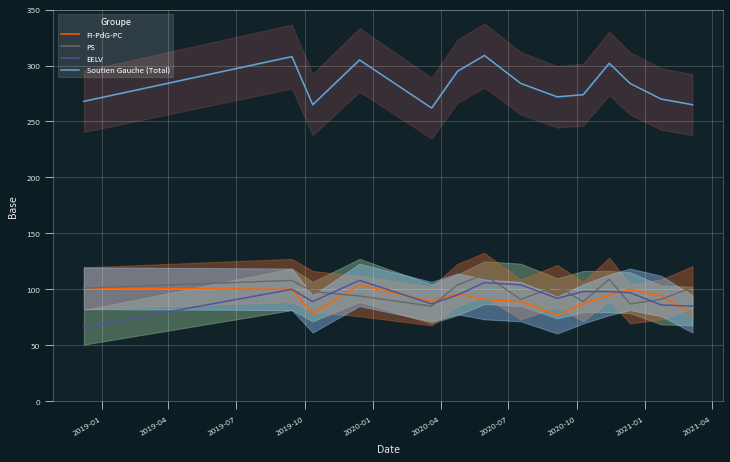

In [184]:
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%m-%Y')

fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
ax=sns.lineplot(data=taille_gauche_full,x='Date',y='Base',hue='Groupe',err_style='band')
ax.set_ylim(0,350)

# # format the ticks
# ax.xaxis.set_major_locator(months)
# ax.xaxis.set_major_formatter(years_fmt)
# # ax.xaxis.set_minor_locator(months)

# # round to nearest years.
# datemin = np.datetime64(taille_gauche_full.Date.min())
# datemax = np.datetime64(taille_gauche_full.Date.max())
# ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# Organise date on ticks automatically
fig.autofmt_xdate()

total_gauche=taille_gauche_full[taille_gauche_full.Groupe=="Soutien Gauche (Total)"]
EELV=taille_gauche_full[taille_gauche_full.Groupe=="EELV"]
PS=taille_gauche_full[taille_gauche_full.Groupe=="PS"]
FI=taille_gauche_full[taille_gauche_full.Groupe=="FI-PdG-PC"]

plt.fill_between(total_gauche.Date, total_gauche.Base-total_gauche.Erreur, total_gauche.Base+total_gauche.Erreur,color='#cc6666', alpha=.2)
plt.fill_between(EELV.Date, EELV.Base-EELV.Erreur, EELV.Base+EELV.Erreur,color='#99cc99', alpha=.4)
plt.fill_between(PS.Date, PS.Base-PS.Erreur, PS.Base+PS.Erreur,color='#cc6633', alpha=.4)
plt.fill_between(FI.Date, FI.Base-FI.Erreur, FI.Base+FI.Erreur,color='#99ccff', alpha=.4)


# Variations personnalité

In [185]:
print(data_f.Categorie.value_counts())
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

Proximitépolitique                   7254
Age                                  5022
PCSdelapersonnederéférencedufoyer    4465
PCSdel'individu                      4463
VotePrésidentielle20171ertour        3906
Région                               3348
Catégoried'agglomération             2790
VotePrésidentielle20172ndtour        2232
Revenumensuelnetdufoyer              2232
Diplômeleplusélevé                   1566
Sexe                                 1116
ENSEMBLE                              558
Niveaud'études                        108
Name: Categorie, dtype: int64


EELV                       558
LR                         558
PS                         558
STCentre(ModemLREM)        558
UDI                        558
LREM                       558
STFIPdGPC                  558
RN                         558
STGauche(FIPdGPCPSEELV)    558
Aucunparti                 558
STDroite(LRUDI)            558
MoDem                      558
DLF                        558
Name: Groupe, dtype: int64

In [186]:
nom='Jean CASTEX'
data_pers=data_f[(data_f.Nom==nom) & (data_f.Groupe=='ENSEMBLE')]
data_pers['Erreur favorable']=error_p(data_pers['ST Favorable']/100,data_pers.Base)*100
data_pers['Erreur défavorable']=error_p(data_pers['ST Défavorable']/100,data_pers.Base)*100
data_pers

D:\Programmes\Python3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Programmes\Python3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable,Erreur favorable,Erreur défavorable
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.8,27.9,32.7,15.8,11.5,27.3,39.9,0.0,0.0,2020-07-18,False,False,2.907619,2.761243,2.907619,2.761243
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.0,32.9,37.0,23.0,18.0,41.0,22.0,4.2,13.7,2020-09-05,False,False,2.992452,3.048414,2.992452,3.048414
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,31.6,35.0,30.4,18.2,48.6,16.4,-2.0,7.6,2020-10-10,True,False,2.956288,3.097817,2.956288,3.097817
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,2.9,28.5,31.4,33.4,26.7,60.1,8.5,-3.6,11.4,2020-11-14,False,False,2.876623,3.035147,2.876623,3.035147
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.1,32.9,36.0,29.7,27.3,57.0,6.9,4.6,-3.0,2020-12-12,False,True,2.975071,3.068511,2.975071,3.068511
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,28.3,31.7,34.3,27.0,61.3,7.0,-4.3,4.3,2021-01-23,False,False,2.884005,3.018852,2.884005,3.018852
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.6,31.6,36.3,32.4,23.5,55.9,7.8,4.6,-5.4,2021-03-06,False,False,2.980431,3.077381,2.980431,3.077381


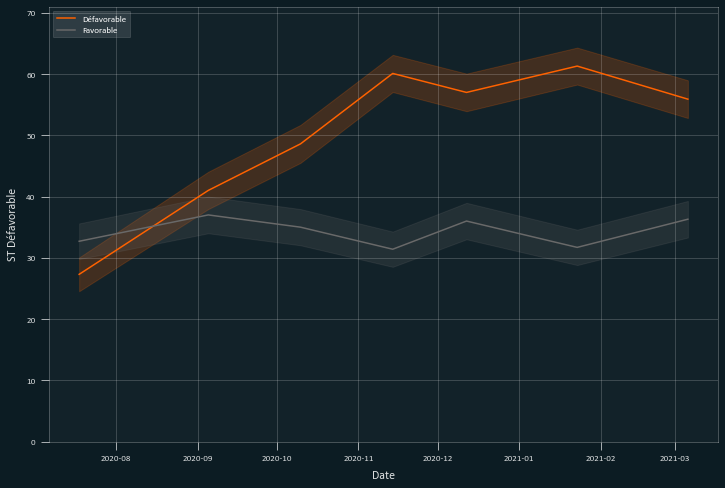

In [187]:


fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')

ax=sns.lineplot(data=data_pers,x='Date',y='ST Défavorable',label='Défavorable')
current_color=ax.get_lines()[0].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Défavorable']-data_pers['Erreur défavorable'], data_pers['ST Défavorable']+data_pers['Erreur défavorable'],color=current_color, alpha=.2)

sns.lineplot(data=data_pers,x='Date',y='ST Favorable',label='Favorable')
current_color=ax.get_lines()[1].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Favorable']-data_pers['Erreur favorable'], data_pers['ST Favorable']+data_pers['Erreur favorable'],color=current_color, alpha=.2)

# Organise date on ticks automatically
# fig.autofmt_xdate()
ax.set_ylim(0,int(np.max([data_pers['ST Favorable'].max(),data_pers['ST Défavorable'].max()]))+10)
plt.legend(loc='upper left')

# Analyse du dernier rapport

In [188]:
all_dates=np.sort(data_f.Date.unique())
most_recent=all_dates[-1]
scd_most_recent=all_dates[-2]

In [189]:
last_data=data_f[data_f.Date==data_f.Date.max()]
last_inex=pd.DataFrame()
last_inex['Résultats']=pd.concat([last_data['ST Favorable'],last_data['ST Défavorable']])
last_inex['Categorie']=pd.concat([last_data['Categorie'],last_data['Categorie']])
last_inex['Groupe']=pd.concat([last_data['Groupe'],last_data['Groupe']])
last_inex['Inexploitable']=pd.concat([last_data['Inexploitable Favorable'],last_data['Inexploitable Défavorable']])
last_inex['Nom']=pd.concat([last_data['Nom'],last_data['Nom']])
last_inex

,Résultats,Categorie,Groupe,Inexploitable,Nom
0,40.9,ENSEMBLE,ENSEMBLE,False,Emmanuel MACRON
1,42.9,Sexe,Homme,False,Emmanuel MACRON
2,39.2,Sexe,Femme,False,Emmanuel MACRON
3,47.0,Age,18à24ans,True,Emmanuel MACRON
4,40.2,Age,25à34ans,True,Emmanuel MACRON
...,...,...,...,...,...
2935,40.8,VotePrésidentielle20171ertour,STNonexpr,True,Laurent WAUQUIEZ
2936,65.7,VotePrésidentielle20172ndtour,EmmanuelMacron,True,Laurent WAUQUIEZ
2937,48.5,VotePrésidentielle20172ndtour,MarineLePen,True,Laurent WAUQUIEZ
2938,59.8,VotePrésidentielle20172ndtour,STExpr,True,Laurent WAUQUIEZ


## Inexploitables global

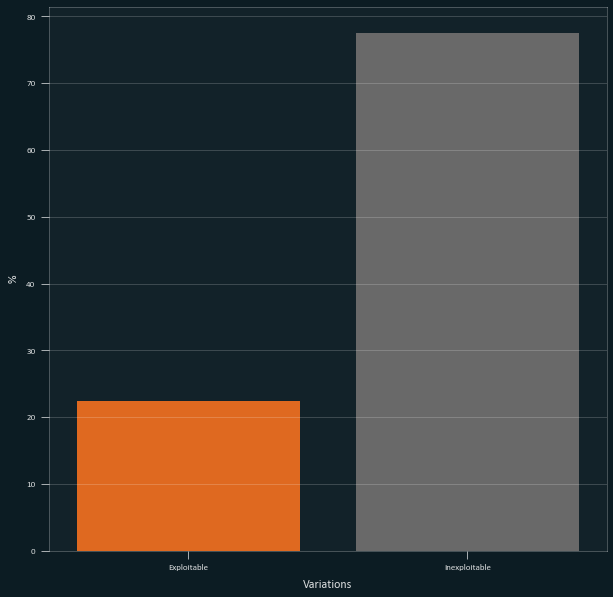

In [190]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=last_inex, estimator=lambda x: len(x) / len(last_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [191]:
print(last_inex.Inexploitable.value_counts())
last_inex.Inexploitable.value_counts()/len(last_inex)

True     4560
False    1320
Name: Inexploitable, dtype: int64


True     0.77551
False    0.22449
Name: Inexploitable, dtype: float64

## Inexploitable par personnalité

### Inexploitable sur tout le jeu de données

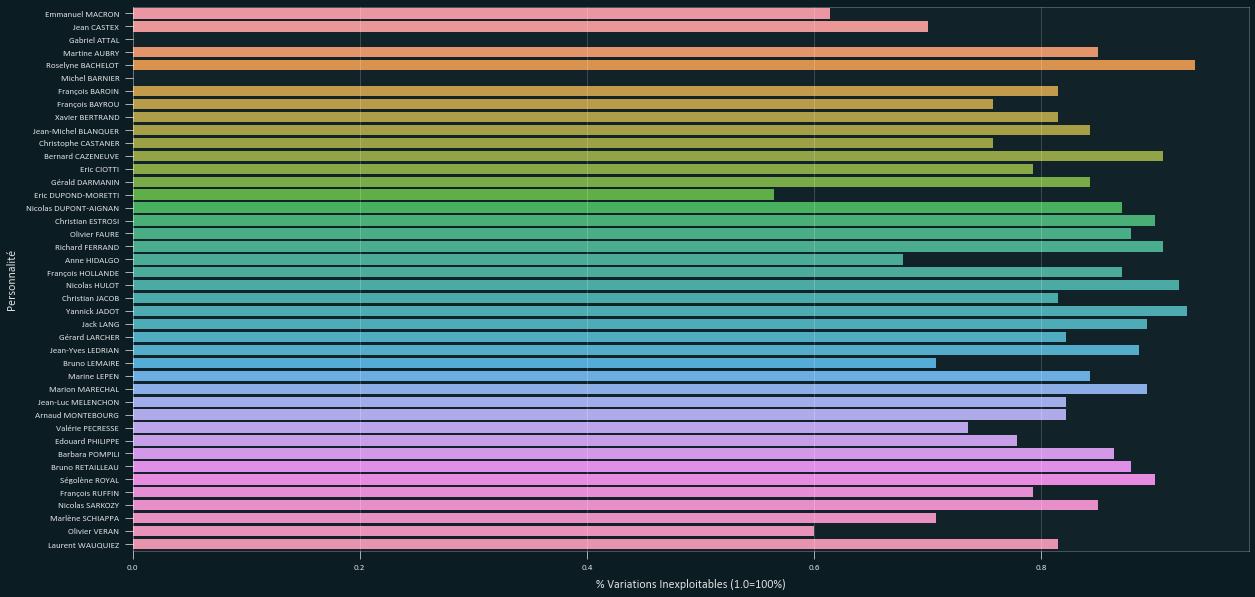

In [192]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [193]:
print(last_inex['Inexploitable'].value_counts()/len(last_inex))
print(last_inex['Inexploitable'].value_counts())

True     0.77551
False    0.22449
Name: Inexploitable, dtype: float64
True     4560
False    1320
Name: Inexploitable, dtype: int64


### Inexploitable sur le groupe ENSEMBLE

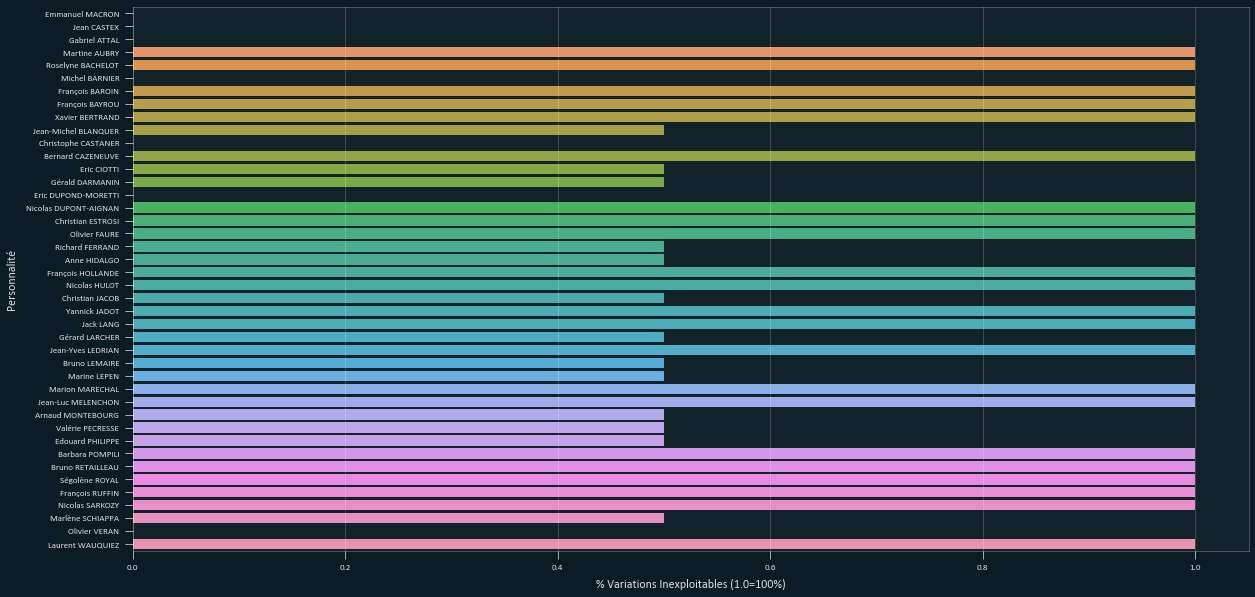

In [194]:
last_inex_ens=last_inex[last_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex_ens,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [195]:
print(last_inex_ens['Inexploitable'].value_counts()/len(last_inex_ens))
print(last_inex_ens['Inexploitable'].value_counts())

True     0.678571
False    0.321429
Name: Inexploitable, dtype: float64
True     57
False    27
Name: Inexploitable, dtype: int64


In [196]:
nom='SCHIA'
categorie='Proximitépolitique'
last_inex[(last_inex.Nom.str.contains(nom))&(last_inex.Inexploitable==False)]

,Résultats,Categorie,Groupe,Inexploitable,Nom
2731,24.2,Sexe,Homme,False,Marlène SCHIAPPA
2736,23.7,Age,45à59ans,False,Marlène SCHIAPPA
2740,23.7,Age,ST35à59ans,False,Marlène SCHIAPPA
2747,20.6,PCSdelapersonnederéférencedufoyer,Ouvrier,False,Marlène SCHIAPPA
2749,25.0,PCSdelapersonnederéférencedufoyer,Inactif,False,Marlène SCHIAPPA
2760,27.5,Région,Nord-Est,False,Marlène SCHIAPPA
2763,23.8,Région,STProvince,False,Marlène SCHIAPPA
2766,23.6,Catégoried'agglomération,20.000à100.000hab,False,Marlène SCHIAPPA
2767,29.0,Catégoried'agglomération,Plusde100.000hab,False,Marlène SCHIAPPA
2769,18.0,Revenumensuelnetdufoyer,Moinsde1.200€,False,Marlène SCHIAPPA


In [197]:
last_inex.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'PCSdelapersonnederéférencedufoyer',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', 'Diplômeleplusélevé',
       'Proximitépolitique', 'VotePrésidentielle20171ertour',
       'VotePrésidentielle20172ndtour'], dtype=object)

## Variation d'une personnalité sur les deux derniers jeux de données

In [198]:
nom="Emmanuel MACRON"
short_d=data_f[(data_f.Nom==nom) & ((data_f.Date==most_recent) | (data_f.Date==scd_most_recent)) & (data_f.Groupe=='Rural')].sort_values(by='Date',ascending=True,ignore_index=True)
print('Favorable')
print((margin_p(short_d['ST Favorable']/100,short_d.Base)*100).T)
print('Défavorable')
print((margin_p(short_d['ST Défavorable']/100,short_d.Base)*100).T)
short_d

Favorable
[[28.05581435 40.34418565]
 [28.91821015 41.28178985]]
Défavorable
[[53.75747754 66.44252246]
 [50.38414749 63.21585251]]


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,8.0,26.2,34.2,33.2,26.9,60.1,5.7,2.8,-3.2,2021-01-23,True,True,6.144186,6.342522
1,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,4.8,30.3,35.1,34.0,22.8,56.8,8.1,0.9,-3.3,2021-03-06,True,True,6.181790,6.415853


In [199]:
data_f[(data_f.Nom==nom) & (data_f.Date==most_recent) & (data_f['Inexploitable Favorable']==False)]

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1000.0,8.1,32.9,40.9,28.2,24.5,52.7,6.4,5.8,-7.0,2021-03-06,False,False,3.047274,3.094510
1,Emmanuel MACRON,Sexe,Homme,476.0,10.3,32.6,42.9,29.6,25.1,54.7,2.5,5.7,-3.1,2021-03-06,False,True,4.446305,4.471934
2,Emmanuel MACRON,Sexe,Femme,524.0,6.0,33.2,39.2,26.8,24.0,50.9,9.9,6.0,-10.5,2021-03-06,False,False,4.180086,4.280456
5,Emmanuel MACRON,Age,35à44ans,140.0,6.3,34.0,40.3,25.7,25.4,51.1,8.6,10.3,-11.2,2021-03-06,False,False,8.125157,8.280507
6,Emmanuel MACRON,Age,45à59ans,296.0,8.7,30.9,39.6,28.9,26.5,55.4,4.9,11.8,-11.9,2021-03-06,False,False,5.571553,5.662817
10,Emmanuel MACRON,Age,ST35à59ans,436.0,8.0,31.9,39.8,27.9,26.2,54.1,6.1,11.3,-11.6,2021-03-06,False,False,4.594652,4.677543
14,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Cadresupérieur,123.0,12.8,43.7,56.5,20.3,18.8,39.1,4.4,16.1,-11.4,2021-03-06,False,False,8.761377,8.623837
16,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Employé,172.0,5.2,33.1,38.3,29.1,23.6,52.7,9.1,11.8,-15.9,2021-03-06,False,False,7.264970,7.461527
20,Emmanuel MACRON,PCSdel'individu,Agriculteurexploitant,10.0,23.5,52.9,76.4,15.7,8.0,23.6,0.0,40.6,-27.2,2021-03-06,False,True,26.318356,26.318356
24,Emmanuel MACRON,PCSdel'individu,Employé,175.0,4.7,36.9,41.6,26.0,23.4,49.4,8.9,14.5,-17.6,2021-03-06,False,False,7.302812,7.407570


# Dernière variation observable

In [200]:


def find_last_var(df):
    last_var={}
    for nom in df.Nom.unique():
        last_var[nom]={'fav':None,'defav':None,'date_fav':None,'date_defav':None}
        df_var=df[(df.Nom==nom) & (df.Categorie=='ENSEMBLE')]
        df_var=df_var.sort_values(by='Date',ascending=False,ignore_index=True)
        l_base=df_var.iloc[0].Base
        l_fav=df_var.iloc[0]['ST Favorable']
        l_defav=df_var.iloc[0]['ST Défavorable']
        er_l_fav=error_p(l_fav/100,l_base)*100
        er_l_defav=error_p(l_defav/100,l_base)*100
        for i in range(1,len(df_var)):
            t=df_var.iloc[i]
            t_base=t.Base
            t_fav=t['ST Favorable']
            t_defav=t['ST Défavorable']
            er_t_fav=error_p(t_fav/100,t_base)*100
            er_t_defav=error_p(t_defav/100,t_base)*100
            # print(l_fav,er_l_fav,t_fav,er_t_fav)
            if l_fav+er_l_fav < t_fav-er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= t_fav-er_t_fav-(l_fav+er_l_fav)
                last_var[nom]['date_fav']= t.Date                
            elif l_fav-er_l_fav > t_fav+er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= l_fav+er_l_fav-(t_fav-er_t_fav)
                last_var[nom]['date_fav']= t.Date                
            if l_defav+er_l_defav < t_defav-er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= t_defav-er_t_defav-(l_defav+er_l_defav)
                last_var[nom]['date_defav']= t.Date                
            elif l_defav-er_l_defav > t_defav+er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= l_defav+er_l_defav-(t_defav-er_t_defav)
                last_var[nom]['date_defav']= t.Date                
    return last_var

In [201]:
nom='Emmanuel MACRON'
last_var=find_last_var(data_f)
last_var[nom] 

{'fav': 18.146713660608288,
 'defav': 0.8653343450534905,
 'date_fav': Timestamp('2019-12-14 00:00:00'),
 'date_defav': Timestamp('2021-01-23 00:00:00')}

In [202]:
def find_last_var_usable(df):
    cols=['Nom','VarFav','DateFav','VarDefav','DateDefav']
    last_var=pd.DataFrame(columns=cols)
    for nom in df.Nom.unique():   
        t_uple=[nom]
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Favorable']==False) & (df['Evolution ST Favorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Favorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
            
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Défavorable']==False) & (df['Evolution ST Défavorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Défavorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
        last_var=last_var.append(pd.Series(t_uple, index=cols),ignore_index=True)
    return last_var


In [203]:
find_last_var_usable(data_f[data_f.Categorie=='ENSEMBLE'])

,Nom,VarFav,DateFav,VarDefav,DateDefav
0,Emmanuel MACRON,5.8,2021-03-06,-7.0,2021-03-06 00:00:00
1,Edouard PHILIPPE,-5.5,2021-01-23,-5.0,2021-03-06 00:00:00
2,Martine AUBRY,-3.5,2020-05-30,-3.8,2020-07-18 00:00:00
3,François BAROIN,3.8,2019-10-12,-4.3,2020-11-14 00:00:00
4,François BAYROU,-3.8,2019-12-14,-3.7,2020-12-12 00:00:00
5,Xavier BERTRAND,5.9,2020-03-20,-3.8,2020-11-14 00:00:00
6,Jean-Michel BLANQUER,-3.6,2021-01-23,-4.0,2021-03-06 00:00:00
7,Agnès BUZYN,-4.8,2020-04-24,8.0,2020-03-20 00:00:00
8,Christophe CASTANER,3.5,2021-03-06,-4.7,2021-03-06 00:00:00
9,Eric CIOTTI,3.5,2020-03-20,-4.7,2021-03-06 00:00:00


## Verification pas de données bizarre

In [204]:
data_f[data_f.Base==0]



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
12,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
82,Edouard PHILIPPE,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
152,Martine AUBRY,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
222,François BAROIN,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
292,François BAYROU,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
362,Xavier BERTRAND,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
432,Jean-Michel BLANQUER,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
502,Agnès BUZYN,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
572,Christophe CASTANER,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
642,Eric CIOTTI,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN


In [205]:
favUnmatch=data_f[np.abs(data_f['Très favorable']+data_f['Plutôt favorable']-data_f['ST Favorable'])>0.11]
favUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [206]:
defavUnmatch=data_f[np.abs(data_f['Très défavorable']+data_f['Plutôt défavorable']-data_f['ST Défavorable'])>0.11]
defavUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [207]:
unmatch=data_f[np.abs(data_f['ST Favorable']+data_f['ST Défavorable']+data_f['Nsp'])<99.89]
unmatch



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
12,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
82,Edouard PHILIPPE,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
152,Martine AUBRY,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
222,François BAROIN,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
292,François BAYROU,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
362,Xavier BERTRAND,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
432,Jean-Michel BLANQUER,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
502,Agnès BUZYN,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
572,Christophe CASTANER,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
642,Eric CIOTTI,PCSdelapersonnederéférencedufoyer,Agriculteurexploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN


In [208]:
dates=np.sort(data_f.Date.unique())
last_date=dates[len(dates)-1]
prev_date=dates[len(dates)-2]
l_data=data_f[data_f.Date==last_date]
p_data=data_f[data_f.Date==prev_date]
l_noms=np.sort(l_data.Nom.unique())
p_noms=np.sort(p_data.Nom.unique())


for nom in l_noms:
    if nom in p_noms:
        lastd=l_data[l_data.Nom==nom]
        prevd=p_data[p_data.Nom==nom]
        lastd['Prev_calc']=lastd['ST Favorable']-lastd['Evolution ST Favorable']
        # check_cond=(l_data.Nom==p_data.Nom) & (l_data.Categorie==p_data.Categorie) & (l_data.Groupe==p_data.Groupe)
        lastd['Prev']= prevd['ST Favorable']
        weird=lastd[np.abs(lastd['Prev'] - lastd['Prev_calc'])> 0.11]
        if len(weird)>0:
            weird
        else:
            print('{} is clear'.format(nom))


D:\Programmes\Python3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Programmes\Python3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
Anne HIDALGO is clear
Arnaud MONTEBOURG is clear
Barbara POMPILI is clear
Bernard CAZENEUVE is clear
Bruno LEMAIRE is clear
Bruno RETAILLEAU is clear
Christian ESTROSI is clear
Christian JACOB is clear
Christophe CASTANER is clear
Edouard PHILIPPE is clear
Emma

In [209]:
for i in weird.index:
    print(p_data.loc[i ])

In [210]:
last_data

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,ENSEMBLE,ENSEMBLE,1000.0,8.1,32.9,40.9,28.2,24.5,52.7,6.4,5.8,-7.0,2021-03-06,False,False,3.047274,3.094510
1,Emmanuel MACRON,Sexe,Homme,476.0,10.3,32.6,42.9,29.6,25.1,54.7,2.5,5.7,-3.1,2021-03-06,False,True,4.446305,4.471934
2,Emmanuel MACRON,Sexe,Femme,524.0,6.0,33.2,39.2,26.8,24.0,50.9,9.9,6.0,-10.5,2021-03-06,False,False,4.180086,4.280456
3,Emmanuel MACRON,Age,18à24ans,106.0,13.0,34.1,47.0,23.1,19.6,42.8,10.2,1.7,-2.5,2021-03-06,True,True,9.501453,9.419396
4,Emmanuel MACRON,Age,25à34ans,159.0,10.9,29.3,40.2,25.9,23.1,49.0,10.8,3.1,-8.9,2021-03-06,True,True,7.621161,7.770351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,Laurent WAUQUIEZ,VotePrésidentielle20171ertour,STNonexpr,252.0,0.5,13.4,13.9,21.5,19.3,40.8,45.3,2.0,-2.6,2021-03-06,True,True,4.271346,6.068016
2936,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,EmmanuelMacron,416.0,2.6,11.1,13.7,35.9,29.8,65.7,20.6,-7.4,4.1,2021-03-06,False,True,3.304267,4.561831
2937,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,MarineLePen,214.0,4.0,25.9,29.9,28.5,20.0,48.5,21.6,3.0,0.5,2021-03-06,True,True,6.134000,6.696127
2938,Laurent WAUQUIEZ,VotePrésidentielle20172ndtour,STExpr,630.0,3.1,16.1,19.2,33.4,26.5,59.8,21.0,-3.9,2.9,2021-03-06,False,True,3.075687,3.828683


# Variation des paramètres non critères pour les quotas

In [211]:
data_f.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'PCSdelapersonnederéférencedufoyer',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', "Niveaud'études", 'Proximitépolitique',
       'VotePrésidentielle20171ertour', 'VotePrésidentielle20172ndtour',
       'Diplômeleplusélevé'], dtype=object)

In [212]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

EELV                       558
LR                         558
PS                         558
STCentre(ModemLREM)        558
UDI                        558
LREM                       558
STFIPdGPC                  558
RN                         558
STGauche(FIPdGPCPSEELV)    558
Aucunparti                 558
STDroite(LRUDI)            558
MoDem                      558
DLF                        558
Name: Groupe, dtype: int64

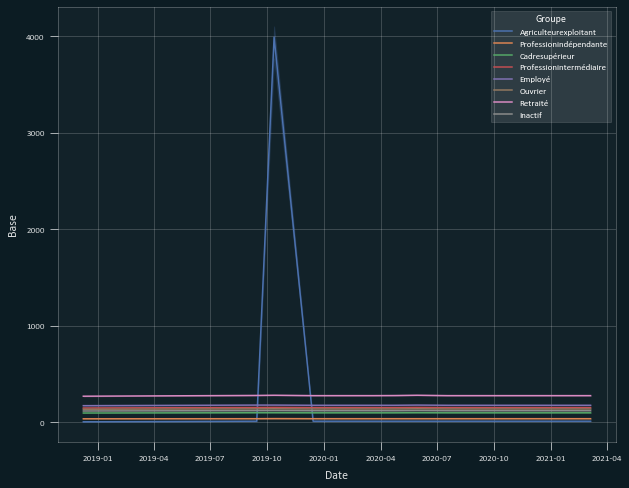

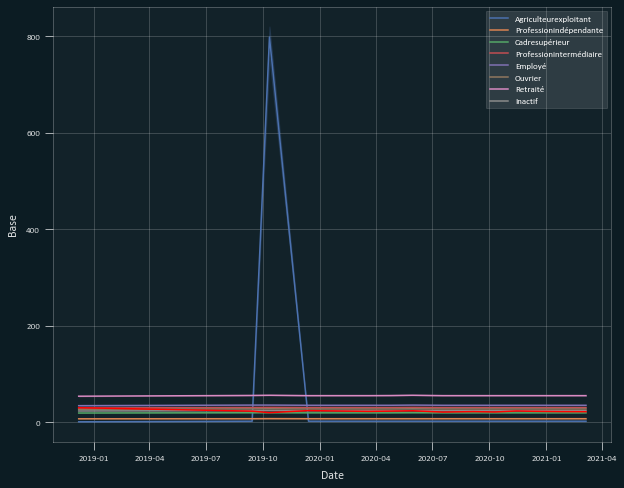

In [216]:
plt.figure(figsize=(10,8))
df_plot=data_f[data_f.Categorie=="PCSdel'individu"]
# df_plot=df_plot[df_plot.Groupe.isin(['STFIPdGPC','PS',"EELV",'LREM','MoDem','UDI','LR','DLF','RN','Aucunparti'])]
sns.lineplot(x='Date',y=df_plot.Base,data=df_plot,hue='Groupe', palette="deep")
plt.figure(figsize=(10,8))
sns.lineplot(x='Date',y=df_plot.Base/5,data=df_plot,hue='Groupe', palette="deep")
sns.lineplot(x='Date',y='ST Favorable',data=data_f[(data_f.Categorie=='ENSEMBLE') & (data_f.Nom=='Jean-Luc MELENCHON')],color='red')

In [214]:
data_f[data_f.Categorie=="PCSdel'individu"].Groupe.unique()

array(['Agriculteurexploitant', 'Professionindépendante',
       'Cadresupérieur', 'Professionintermédiaire', 'Employé', 'Ouvrier',
       'Retraité', 'Inactif'], dtype=object)

In [215]:
data_f.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'PCSdelapersonnederéférencedufoyer',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', "Niveaud'études", 'Proximitépolitique',
       'VotePrésidentielle20171ertour', 'VotePrésidentielle20172ndtour',
       'Diplômeleplusélevé'], dtype=object)